# Assignment 2

In this assignment you will create a coordinate-based multilayer perceptron in numpy from scratch. For each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

You will then compare the following input feature mappings $\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$. 

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$.

Some notes to help you with that:

- You will implement the mappings in the helper functions `get_B_dict` and `input_mapping`. 
- The basic mapping can be considered a case where $\mathbf B \in \mathbb R^{2 \times 2}$ is the indentity matrix. 
- For this assignment, $d$ is 2 because the input coordinates in two dimensions. 
- You can experiment with $m$ and $\sigma$ values e.g. $m=256$ and $\sigma \in \{1, 10, 100\}$.

Source: https://bmild.github.io/fourfeat/ 
This assignment is inspired by and built off of the authors' demo. 

## Setup

### (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. Replace the path below with the path in your Google Drive to the uploaded assignment folder. Mounting to Google Drive will allow you access the other .py files in the assignment folder and save outputs to this folder

In [ ]:
# you will be prompted with a window asking to grant permissions
# click connect to google drive, choose your account, and click allow
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# TODO: fill in the path in your Google Drive in the string below
# Note: do not escape slashes or spaces in the path string
import os
datadir = "/content/assignment2"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/path/to/your/assignment2/" $datadir
os.chdir(datadir)
!pwd

### Imports

In [34]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio
import cv2
import numpy as np

# imports /content/assignment2/models/neural_net.py if you mounted correctly 
from models.neural_net import NeuralNetwork

# makes sure your NeuralNetwork updates as you make changes to the .py file
%load_ext autoreload
%autoreload 2

# sets default size of plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helper Functions

### Experiment Runner (Fill in TODOs)

In [111]:

def NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                  hidden_size, output_size, epochs,\
                  learning_rate, opt, batch_size=200):
    n_samples = X_train.shape[0]
    
    hidden_sizes = [hidden_size] * (num_layers - 1)
    # Initialize a new neural network model
    net = NeuralNetwork(input_size, hidden_sizes, output_size, num_layers, opt)

    # Variables to store performance for each epoch
    train_loss = np.zeros(epochs)
    train_psnr = np.zeros(epochs)
    test_psnr = np.zeros(epochs)
    predicted_images = np.zeros((epochs, y_test.shape[0], y_test.shape[1]))
    
    num_iteration = 0
    # For each epoch...
    for epoch in tqdm(range(epochs)):

        # Shuffle the dataset
        # TODO implement this
        ind_list = list(range(n_samples))
        np.random.shuffle(ind_list)
        X_train  = X_train[ind_list, :]
        y_train = y_train[ind_list,]

        for index in range(0, n_samples, batch_size):
            # if (index != 0):
            #     continue
            batch_X = X_train[index:min(index + batch_size, n_samples),:]
            batch_y = y_train[index:min(index + batch_size, n_samples)]
            output_y = net.forward(batch_X)
            loss = net.backward(batch_y)
            num_iteration += 1
            net.update(lr=learning_rate, iteration=num_iteration)
        
        p = net.forward(X_train)
        loss = net.mse(y_train, p)
        train_loss[epoch] = loss
        train_psnr[epoch] = -10*np.log10(loss)
        
        p_test = net.forward(X_test)
        test_loss = net.mse(y_test, p_test)
        test_psnr[epoch] = -10*np.log10(test_loss)
        
        predicted_images[epoch] = p_test
        if(epoch % 50 == 0):
            print(f"Epoch {epoch}, train_loss:{loss:.8f}, test_loss:{test_loss:.8f}")

    return net, train_psnr, test_psnr, train_loss, predicted_images

### Image Data and Feature Mappings (Fill in TODOs)

In [36]:
# Data loader - already done for you
def get_image(size=512, \
              image_url='https://bmild.github.io/fourfeat/img/lion_orig.png'):

    # Download image, take a square crop from the center  
    img = imageio.imread(image_url)[..., :3] / 255.
    c = [img.shape[0]//2, img.shape[1]//2]
    r = 256
    img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

    if size != 512:
        img = cv2.resize(img, (size, size))

    plt.imshow(img)
    plt.show()

    # Create input pixel coordinates in the unit square
    coords = np.linspace(0, 1, img.shape[0], endpoint=False)
    x_test = np.stack(np.meshgrid(coords, coords), -1)
    test_data = [x_test, img]
    train_data = [x_test[::2, ::2], img[::2, ::2]]
    return train_data, test_data


In [55]:
# Create the mappings dictionary of matrix B -  you will implement this
def get_B_dict():
    B_dict = {}
    B_dict['none'] = None

    # add B matrix for basic, gauss_1.0, gauss_10.0, gauss_100.0
    # TODO implement this
    m = 256
    B_dict['basic'] = np.eye(2)
    B_dict['gauss_1.0'] = np.random.normal(0, 1, (m, 2))
    B_dict['gauss_10.0'] = np.random.normal(0, 10, (m, 2))
    B_dict['gauss_100.0'] = np.random.normal(0, 100, (m, 2))
    
    return B_dict

In [74]:
# Given tensor x of input coordinates, map it using B - you will implement
def input_mapping(x, B):
    if B is None:
        # "none" mapping - just returns the original input coordinates
        return x
    else:
        # "basic" mapping and "gauss_X" mappings project input features using B
        # TODO implement this
        m = B.shape[0]
        new_n_features = m * 2
        res = np.zeros((x.shape[0], new_n_features))
        for n in range(x.shape[0]):
            v = x[n] # (2, )
            Bv = B @ v # (m, 1)
            res[n, 0:m] = np.cos(2*np.pi*Bv)
            res[n, m:] = np.sin(2*np.pi*Bv)
        return res

In [39]:
# Apply the input feature mapping to the train and test data - already done for you
def get_input_features(train_data, test_data, B_dict, mapping):
    # mapping is the key to the B_dict, which has the value of B
    # B is then used with the function `input_mapping` to map x  
    output_size = 3
    y_train = train_data[1].reshape(-1, output_size)
    y_test = test_data[1].reshape(-1, output_size)
    X_train = input_mapping(train_data[0].reshape(-1, 2), B_dict[mapping])
    X_test = input_mapping(test_data[0].reshape(-1, 2), B_dict[mapping])
    return X_train, y_train, X_test, y_test

### MSE Loss and PSNR Error (Fill in TODOs)

In [40]:
def mse(y, p):
    # TODO implement this
    # make sure it is consistent with your implementation in neural_net.py
    return np.sum((y - p)**2) / y.shape[0]

def psnr(y, p):
    # TODO implement this
    mse = np.sum((y - p)**2) / y.shape[0]
    return -10*np.log10(mse)

### Plotting

In [41]:
def plot_training_curves(train_loss, train_psnr, test_psnr):
    # plot the training loss
    plt.subplot(2, 1, 1)
    plt.plot(train_loss)
    plt.title('MSE history')
    plt.xlabel('Iteration')
    plt.ylabel('MSE Loss')

    # plot the training and testing psnr
    plt.subplot(2, 1, 2)
    plt.plot(train_psnr, label='train')
    plt.plot(test_psnr, label='test')
    plt.title('PSNR history')
    plt.xlabel('Iteration')
    plt.ylabel('PSNR')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [42]:
def plot_reconstruction(p, y_test):
    p_im = p.reshape(size,size,3)
    y_im = y_test.reshape(size,size,3)

    plt.figure(figsize=(12,6))

    # plot the reconstruction of the image
    plt.subplot(1,2,1), plt.imshow(p_im), plt.title("reconstruction")

    # plot the ground truth image
    plt.subplot(1,2,2), plt.imshow(y_im), plt.title("ground truth")

    print("Final Test MSE", mse(y_test, p))
    print("Final Test psnr",psnr(y_test, p))

In [43]:
def plot_reconstruction_progress(predicted_images, y_test, N=8):
    total = len(predicted_images)
    step = total // N
    plt.figure(figsize=(24, 4))

    # plot the progress of reconstructions
    for i, j in enumerate(range(0,total, step)):
        plt.subplot(1, N, i+1)
        plt.imshow(predicted_images[j].reshape(size,size,3))
        plt.axis("off")
        plt.title(f"iter {j}")

    # plot ground truth image
    plt.subplot(1, N+1, N+1)
    plt.imshow(y_test.reshape(size,size,3))
    plt.title('GT')
    plt.axis("off")
    plt.show()

In [86]:
def plot_feature_mapping_comparison(outputs, gt):
    # plot reconstruction images for each mapping
    plt.figure(figsize=(24, 4))
    N = len(outputs)
    for i, k in enumerate(outputs):
        plt.subplot(1, N+1, i+1)
        plt.imshow(outputs[k]['pred_imgs'][-1].reshape(size, size, -1))
        plt.title(k)
    plt.subplot(1, N+1, N+1)
    plt.imshow(gt)
    plt.title('GT')
    plt.show()

    # plot train/test error curves for each mapping
    iters = len(outputs[k]['train_psnr'])
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    for i, k in enumerate(outputs):
        plt.plot(range(iters), outputs[k]['train_psnr'], label=k)
    plt.title('Train error')
    plt.ylabel('PSNR')
    plt.xlabel('Training iter')
    plt.legend()
    plt.subplot(122)
    for i, k in enumerate(outputs):
        plt.plot(range(iters), outputs[k]['test_psnr'], label=k)
    plt.title('Test error')
    plt.ylabel('PSNR')
    plt.xlabel('Training iter')
    plt.legend()
    plt.show()

In [143]:
# Save out video
def create_and_visualize_video(outputs, size, epochs, filename='training_convergence.mp4'):
    all_preds = np.concatenate([outputs[n]['pred_imgs'].reshape(epochs,size,size,3)[::25] for n in outputs], axis=-2)
    data8 = (255*np.clip(all_preds, 0, 1)).astype(np.uint8)
    f = os.path.join(filename)
    imageio.mimwrite(f, data8, fps=20)

    # Display video inline
    from IPython.display import HTML
    from base64 import b64encode
    mp4 = open(f, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

    N = len(outputs)
    if N == 1:
        return HTML(f'''
        <video width=256 controls autoplay loop>
              <source src="{data_url}" type="video/mp4">
        </video>
        ''')
    else:
        return HTML(f'''
        <video width=1000 controls autoplay loop>
              <source src="{data_url}" type="video/mp4">
        </video>
        <table width="1000" cellspacing="0" cellpadding="0">
          <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
          <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
        </table>
        '''.format(*list(outputs.keys())))

# Low Resolution Reconstruction

/tmp/ipykernel_5476/1395671467.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


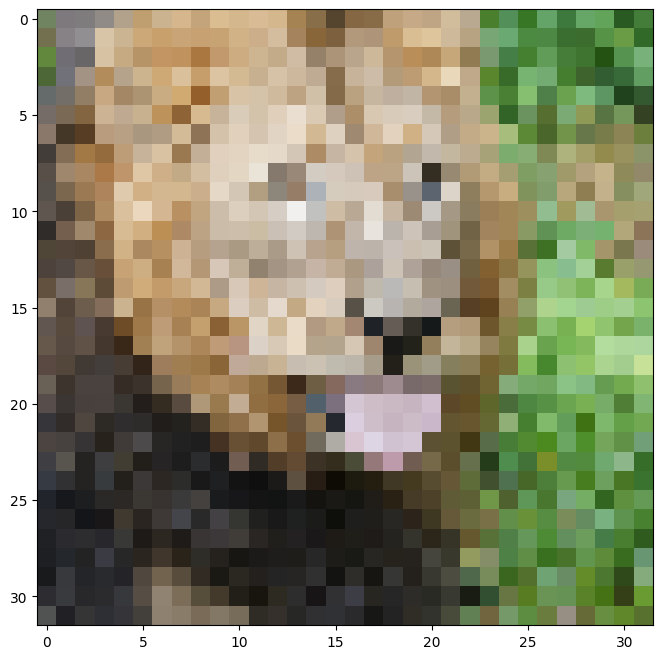

In [128]:
size = 32
train_data, test_data = get_image(size)

Some suggested hyperparameter choices to help you start
- hidden layer count: 4
- hidden layer size: 256
- number of epochs: 1000
- learning reate: 1e-4


#### Low Resolution Reconstruction - SGD - None Mapping

(256, 2)
(256, 3)
(1024, 2)
(1024, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.14882073, test_loss:0.14796795
Epoch 50, train_loss:0.10443130, test_loss:0.10332682
Epoch 100, train_loss:0.09600109, test_loss:0.09393691
Epoch 150, train_loss:0.09178482, test_loss:0.08967374
Epoch 200, train_loss:0.08817877, test_loss:0.08520386
Epoch 250, train_loss:0.08478837, test_loss:0.08223321
Epoch 300, train_loss:0.08194168, test_loss:0.07909687
Epoch 350, train_loss:0.07946211, test_loss:0.07637528
Epoch 400, train_loss:0.07761345, test_loss:0.07411511
Epoch 450, train_loss:0.07527240, test_loss:0.07216760
Epoch 500, train_loss:0.07343775, test_loss:0.07047028
Epoch 550, train_loss:0.07188592, test_loss:0.06911522
Epoch 600, train_loss:0.07094740, test_loss:0.06748856
Epoch 650, train_loss:0.06943605, test_loss:0.06652242
Epoch 700, train_loss:0.06908855, test_loss:0.06565216
Epoch 750, train_loss:0.06771817, test_loss:0.06477823
Epoch 800, train_loss:0.06710440, test_loss:0.06408428
Epoch 850, train_loss:0.06620330, test_loss:0.06375019
Epoch 900, tr

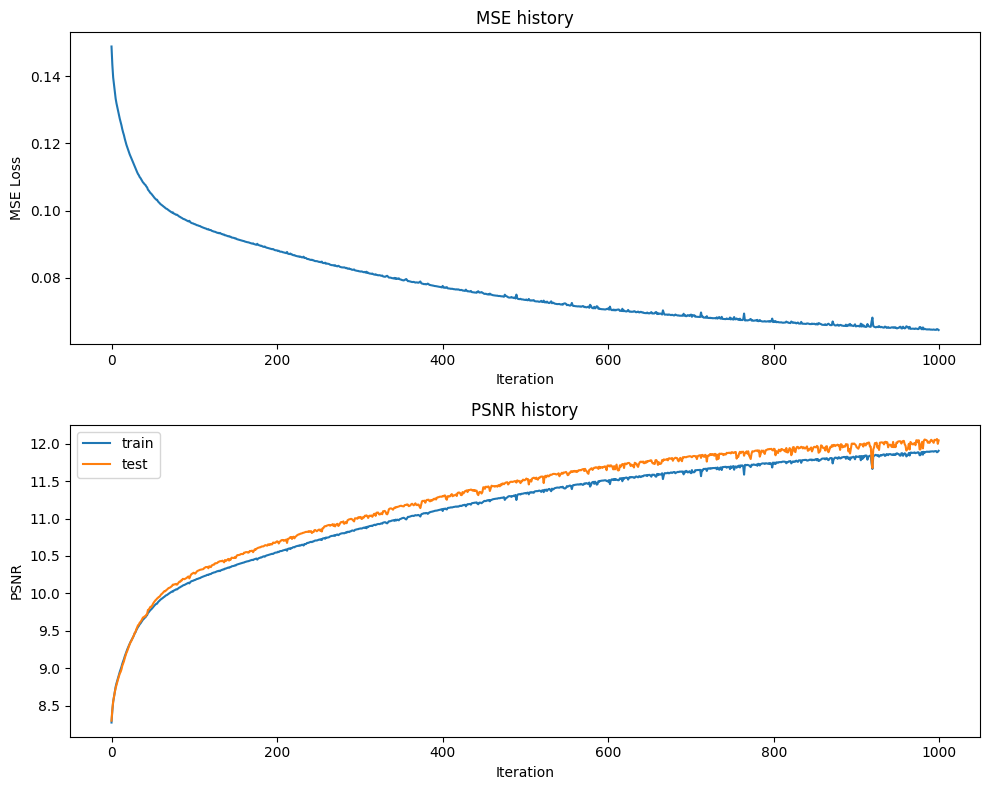

Final Test MSE 0.062461658397627746
Final Test psnr 12.043864891519757


/tmp/ipykernel_5476/3375680043.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, N+1, N+1)


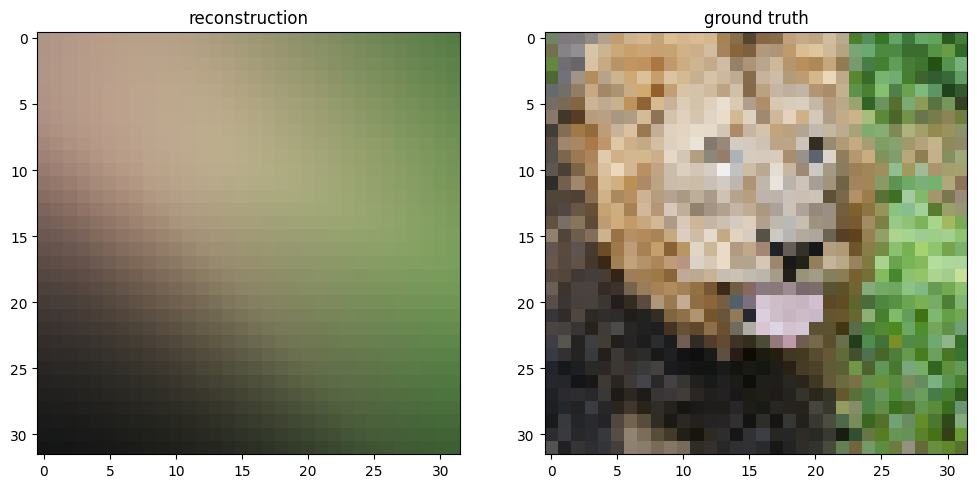

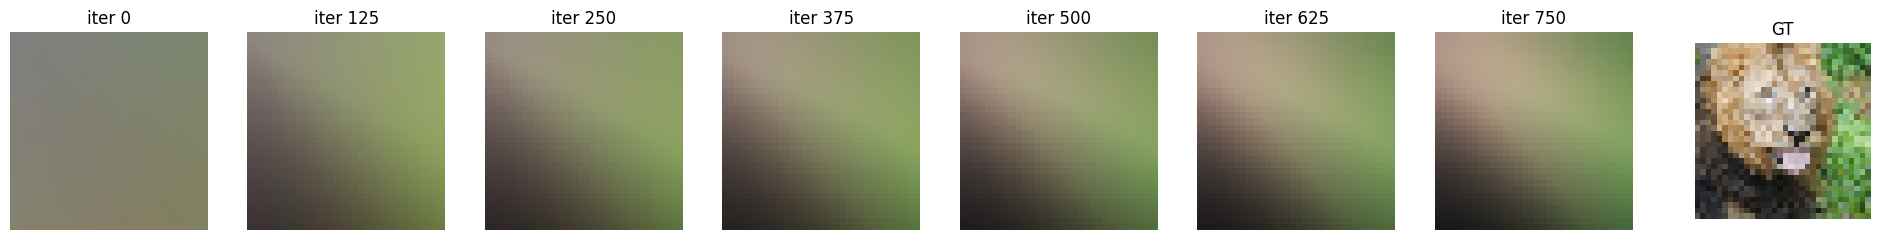

In [129]:
# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions
B_dict = get_B_dict()
# basic, gauss_1.0, gauss_10.0, gauss_100.0
X_train, y_train, X_test, y_test = get_input_features(train_data, test_data, B_dict, mapping="none")

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

input_size = X_train.shape[1]
# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test,
                                                                        input_size=input_size,
                                                                        num_layers=4,
                                                                        hidden_size=256,
                                                                        output_size=3,
                                                                        epochs=1000,
                                                                        learning_rate=0.01,
                                                                        batch_size=50,
                                                                        opt="SGD")

# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### Low Resolution Reconstruction - Adam - None Mapping

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.11520650, test_loss:0.11422458
Epoch 50, train_loss:0.04446536, test_loss:0.04862888
Epoch 100, train_loss:0.03687104, test_loss:0.04168991
Epoch 150, train_loss:0.03418733, test_loss:0.04016618
Epoch 200, train_loss:0.03778971, test_loss:0.04280399
Epoch 250, train_loss:0.04182267, test_loss:0.04639309
Epoch 300, train_loss:0.03004842, test_loss:0.03695118
Epoch 350, train_loss:0.03000854, test_loss:0.03936147
Epoch 400, train_loss:0.02865856, test_loss:0.03942361
Epoch 450, train_loss:0.02274118, test_loss:0.03472086
Epoch 500, train_loss:0.02039548, test_loss:0.03511974
Epoch 550, train_loss:0.01894803, test_loss:0.03499100
Epoch 600, train_loss:0.02305671, test_loss:0.03899625
Epoch 650, train_loss:0.01811598, test_loss:0.03473141
Epoch 700, train_loss:0.03005478, test_loss:0.04303356
Epoch 750, train_loss:0.01549029, test_loss:0.03672061
Epoch 800, train_loss:0.02714339, test_loss:0.03893162
Epoch 850, train_loss:0.02306402, test_loss:0.03498895
Epoch 900, tr

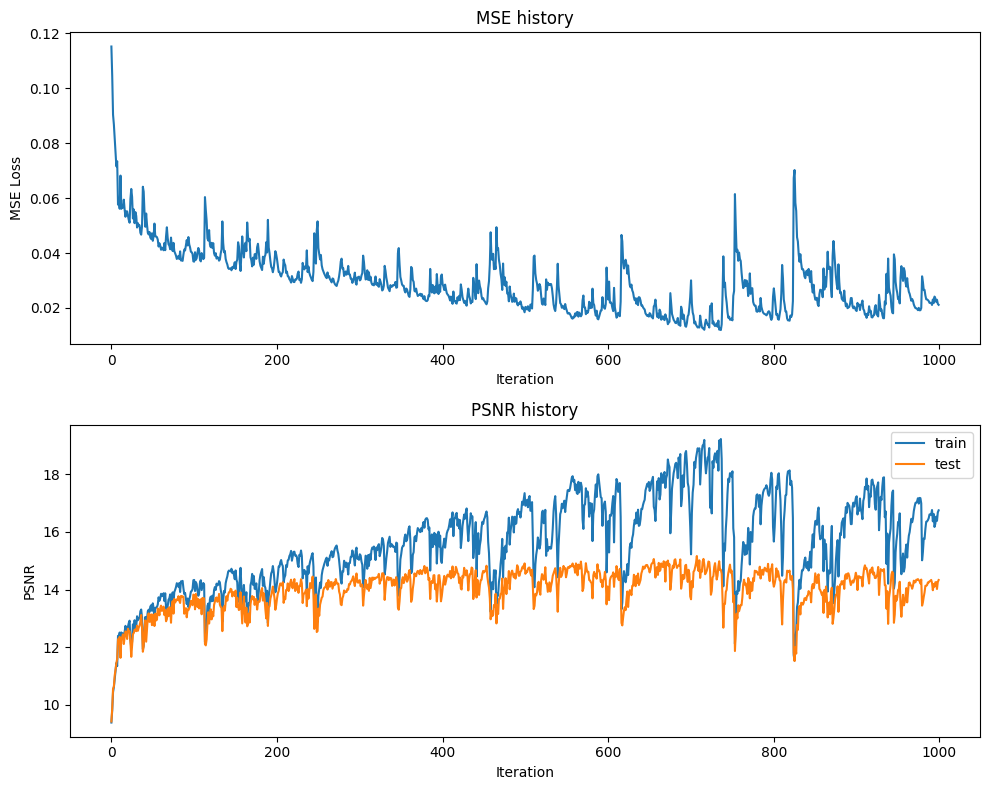

Final Test MSE 0.036901452846848815
Final Test psnr 14.329565348992459


/tmp/ipykernel_5476/3375680043.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, N+1, N+1)


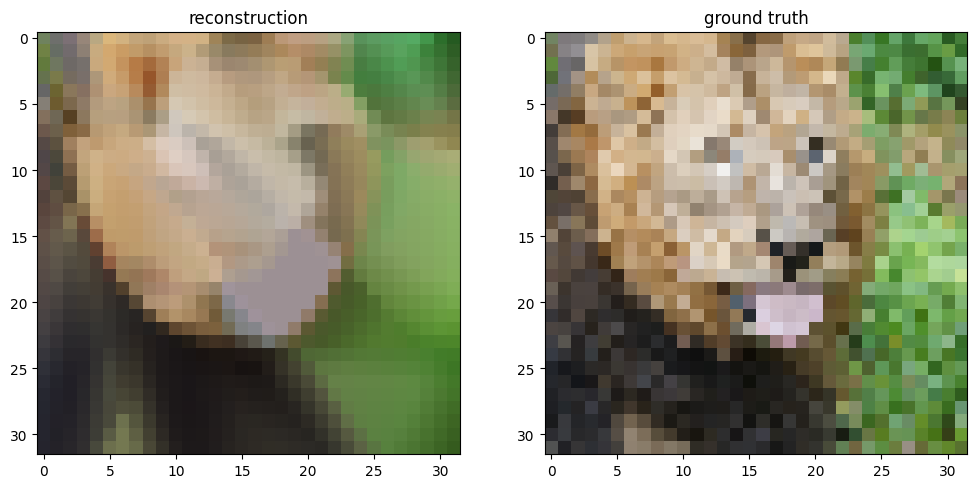

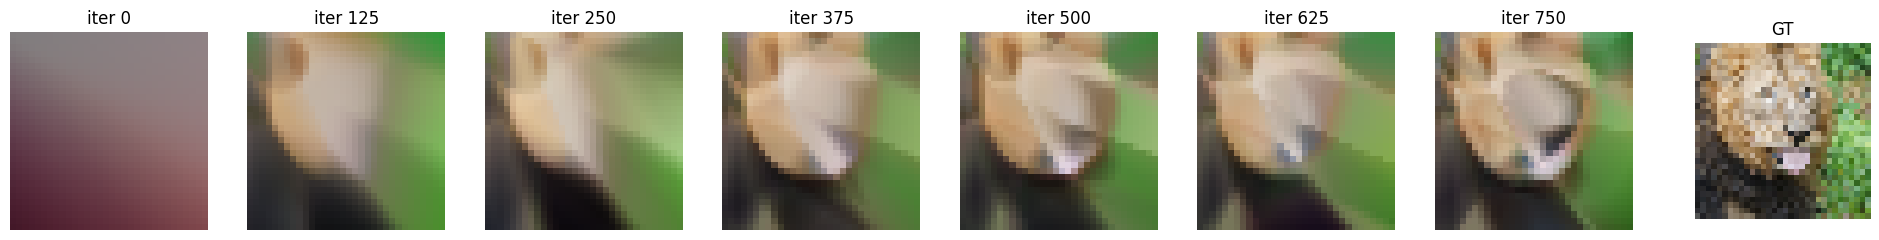

In [130]:
B_dict = get_B_dict()
X_train, y_train, X_test, y_test = get_input_features(train_data, test_data, B_dict, mapping="none")

# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
input_size = X_train.shape[1]
net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test,
                                                                        input_size=input_size,
                                                                        num_layers=4,
                                                                        hidden_size=256,
                                                                        output_size=3,
                                                                        epochs=1000,
                                                                        learning_rate=0.01,
                                                                        batch_size=50,
                                                                        opt="Adam")

# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### Low Resolution Reconstruction - Optimizer of your Choice - Various Input Mapping Stategies

In [131]:
def train_wrapper(train_data, test_data, B_dict, mapping, size, opt):
    # TODO implement
    # makes it easy to run all your mapping experiments in a for loop
    # this will similar to what you did previously in the last two sections
    X_train, y_train, X_test, y_test = get_input_features(train_data, test_data, B_dict, mapping=mapping)
    
    input_size = X_train.shape[1]
    # run NN experiment on input features
    # TODO implement by using the NN_experiment() helper function
    net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test,
                                                                            input_size=input_size,
                                                                            num_layers=4,
                                                                            hidden_size=256,
                                                                            output_size=3,
                                                                            epochs=1000,
                                                                            learning_rate=0.001,
                                                                            batch_size=50,
                                                                            opt=opt)

    return {
      'net': net, 
      'train_psnr': train_psnr, 
      'test_psnr': test_psnr,
      'train_loss': train_loss,
      'pred_imgs': predicted_images
    }



/tmp/ipykernel_5476/1395671467.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


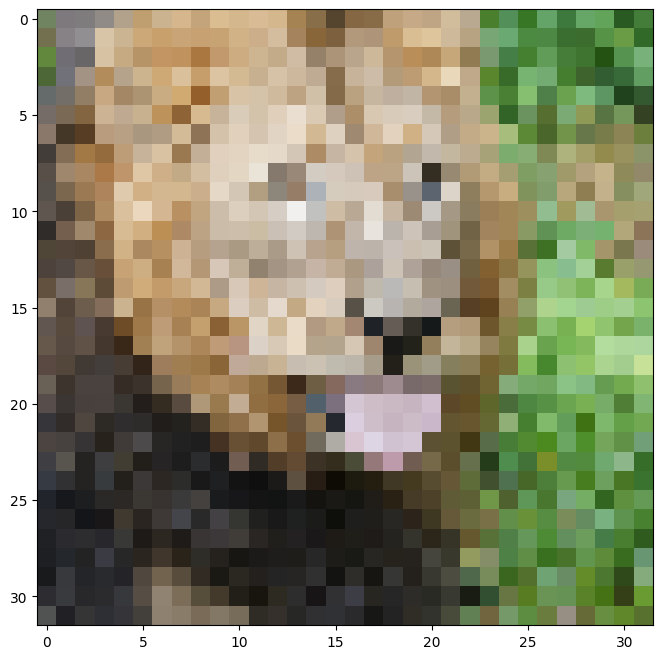

  0%|          | 0/5 [00:00<?, ?it/s]


========== training none


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.17190707, test_loss:0.17074108
Epoch 50, train_loss:0.14019015, test_loss:0.14001399
Epoch 100, train_loss:0.12992713, test_loss:0.13037244
Epoch 150, train_loss:0.12431405, test_loss:0.12501736
Epoch 200, train_loss:0.12027934, test_loss:0.12093205
Epoch 250, train_loss:0.11696746, test_loss:0.11749429
Epoch 300, train_loss:0.11421075, test_loss:0.11452143
Epoch 350, train_loss:0.11171813, test_loss:0.11181697
Epoch 400, train_loss:0.10943892, test_loss:0.10921370
Epoch 450, train_loss:0.10746214, test_loss:0.10704307
Epoch 500, train_loss:0.10580346, test_loss:0.10516951
Epoch 550, train_loss:0.10429517, test_loss:0.10356723
Epoch 600, train_loss:0.10289438, test_loss:0.10201513
Epoch 650, train_loss:0.10169072, test_loss:0.10056039
Epoch 700, train_loss:0.10064491, test_loss:0.09940960
Epoch 750, train_loss:0.09970724, test_loss:0.09836445
Epoch 800, train_loss:0.09887673, test_loss:0.09744443
Epoch 850, train_loss:0.09811787, test_loss:0.09646003
Epoch 900, tr

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.16527250, test_loss:0.16396463
Epoch 50, train_loss:0.13601464, test_loss:0.13541913
Epoch 100, train_loss:0.12049982, test_loss:0.12028489
Epoch 150, train_loss:0.10968159, test_loss:0.10964149
Epoch 200, train_loss:0.10130485, test_loss:0.10140852
Epoch 250, train_loss:0.09438470, test_loss:0.09460069
Epoch 300, train_loss:0.08858658, test_loss:0.08882056
Epoch 350, train_loss:0.08376945, test_loss:0.08405853
Epoch 400, train_loss:0.07985968, test_loss:0.08015859
Epoch 450, train_loss:0.07659487, test_loss:0.07697207
Epoch 500, train_loss:0.07394244, test_loss:0.07429898
Epoch 550, train_loss:0.07171860, test_loss:0.07212676
Epoch 600, train_loss:0.06993183, test_loss:0.07039501
Epoch 650, train_loss:0.06839325, test_loss:0.06884500
Epoch 700, train_loss:0.06701601, test_loss:0.06755570
Epoch 750, train_loss:0.06582029, test_loss:0.06636187
Epoch 800, train_loss:0.06477645, test_loss:0.06532429
Epoch 850, train_loss:0.06384896, test_loss:0.06444491
Epoch 900, tr

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.17212840, test_loss:0.17188440
Epoch 50, train_loss:0.13745097, test_loss:0.13750328
Epoch 100, train_loss:0.11657847, test_loss:0.11663766
Epoch 150, train_loss:0.10139413, test_loss:0.10135378
Epoch 200, train_loss:0.08844007, test_loss:0.08840741
Epoch 250, train_loss:0.07798016, test_loss:0.07792782
Epoch 300, train_loss:0.06966517, test_loss:0.06960056
Epoch 350, train_loss:0.06300246, test_loss:0.06299968
Epoch 400, train_loss:0.05792558, test_loss:0.05806595
Epoch 450, train_loss:0.05406298, test_loss:0.05431774
Epoch 500, train_loss:0.05105463, test_loss:0.05148585
Epoch 550, train_loss:0.04869183, test_loss:0.04927941
Epoch 600, train_loss:0.04687241, test_loss:0.04768482
Epoch 650, train_loss:0.04542045, test_loss:0.04642765
Epoch 700, train_loss:0.04420014, test_loss:0.04543986
Epoch 750, train_loss:0.04312932, test_loss:0.04454229
Epoch 800, train_loss:0.04219825, test_loss:0.04383659
Epoch 850, train_loss:0.04138780, test_loss:0.04318185
Epoch 900, tr

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.16029641, test_loss:0.16235907
Epoch 50, train_loss:0.14766577, test_loss:0.15185417
Epoch 100, train_loss:0.14284050, test_loss:0.14874998
Epoch 150, train_loss:0.13960826, test_loss:0.14724073
Epoch 200, train_loss:0.13692906, test_loss:0.14617442
Epoch 250, train_loss:0.13441331, test_loss:0.14524179
Epoch 300, train_loss:0.13194745, test_loss:0.14434893
Epoch 350, train_loss:0.12942967, test_loss:0.14339359
Epoch 400, train_loss:0.12689698, test_loss:0.14245633
Epoch 450, train_loss:0.12429091, test_loss:0.14155795
Epoch 500, train_loss:0.12163435, test_loss:0.14055628
Epoch 550, train_loss:0.11884968, test_loss:0.13957222
Epoch 600, train_loss:0.11603110, test_loss:0.13854393
Epoch 650, train_loss:0.11312954, test_loss:0.13745811
Epoch 700, train_loss:0.11011801, test_loss:0.13636418
Epoch 750, train_loss:0.10699782, test_loss:0.13519652
Epoch 800, train_loss:0.10374861, test_loss:0.13401092
Epoch 850, train_loss:0.10042979, test_loss:0.13278453
Epoch 900, tr

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.16859404, test_loss:0.16967165
Epoch 50, train_loss:0.15045006, test_loss:0.15383812
Epoch 100, train_loss:0.14373808, test_loss:0.14901419
Epoch 150, train_loss:0.14049896, test_loss:0.14742397
Epoch 200, train_loss:0.13801935, test_loss:0.14656448
Epoch 250, train_loss:0.13587909, test_loss:0.14601282
Epoch 300, train_loss:0.13384054, test_loss:0.14551929
Epoch 350, train_loss:0.13178216, test_loss:0.14503656
Epoch 400, train_loss:0.12973347, test_loss:0.14457158
Epoch 450, train_loss:0.12767397, test_loss:0.14411267
Epoch 500, train_loss:0.12558146, test_loss:0.14365043
Epoch 550, train_loss:0.12345643, test_loss:0.14316362
Epoch 600, train_loss:0.12126058, test_loss:0.14269400
Epoch 650, train_loss:0.11908643, test_loss:0.14227949
Epoch 700, train_loss:0.11681733, test_loss:0.14175926
Epoch 750, train_loss:0.11451624, test_loss:0.14129564
Epoch 800, train_loss:0.11209275, test_loss:0.14081681
Epoch 850, train_loss:0.10959184, test_loss:0.14034699
Epoch 900, tr

In [146]:
outputs = {}
size = 32
train_data, test_data = get_image(size)
B_dict = get_B_dict()
opt = "SGD"
for k in tqdm(B_dict):
    print("\n========== training", k)
    outputs[k] = train_wrapper(train_data, test_data, B_dict, k, size, opt)

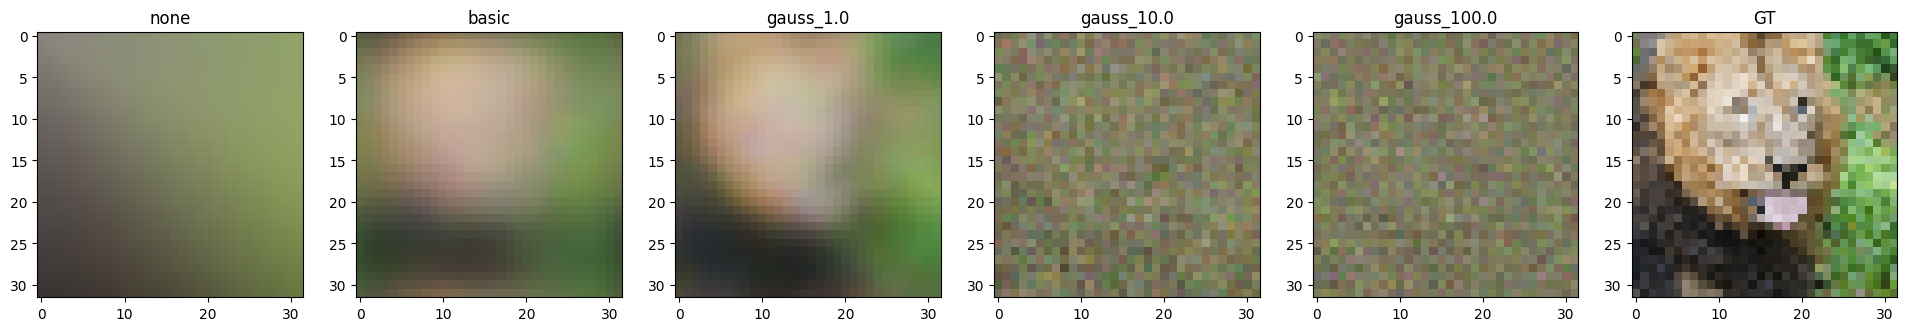

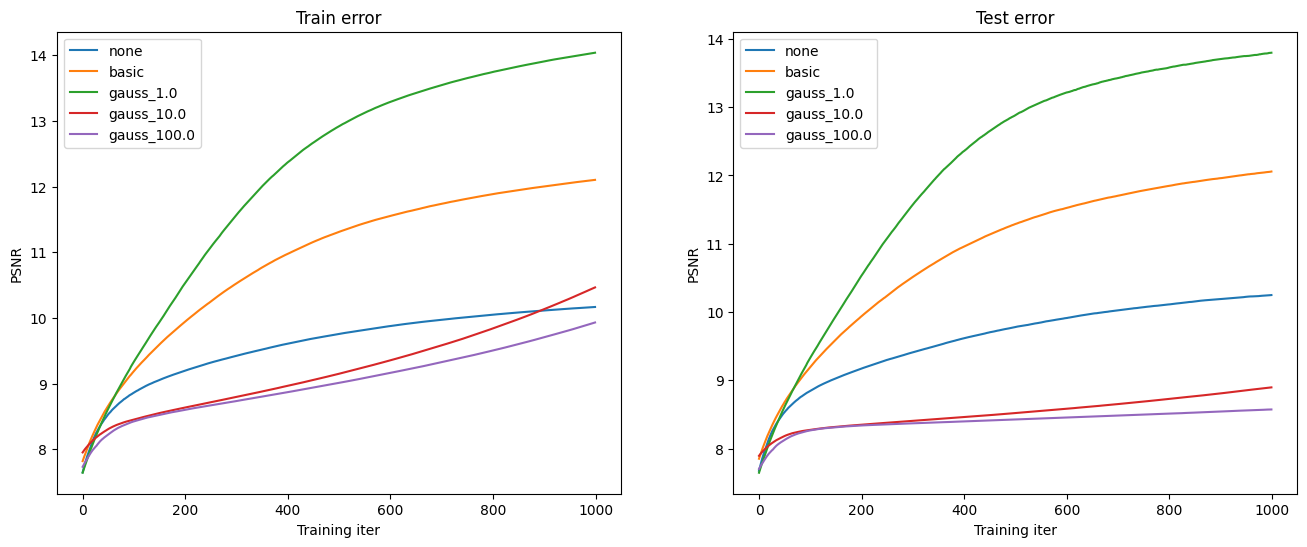

In [148]:
_, _, _, y_test = get_input_features(train_data, test_data, B_dict, mapping="none")
# if you did everything correctly so far, this should output a nice figure you can use in your report
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

/tmp/ipykernel_5476/1395671467.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


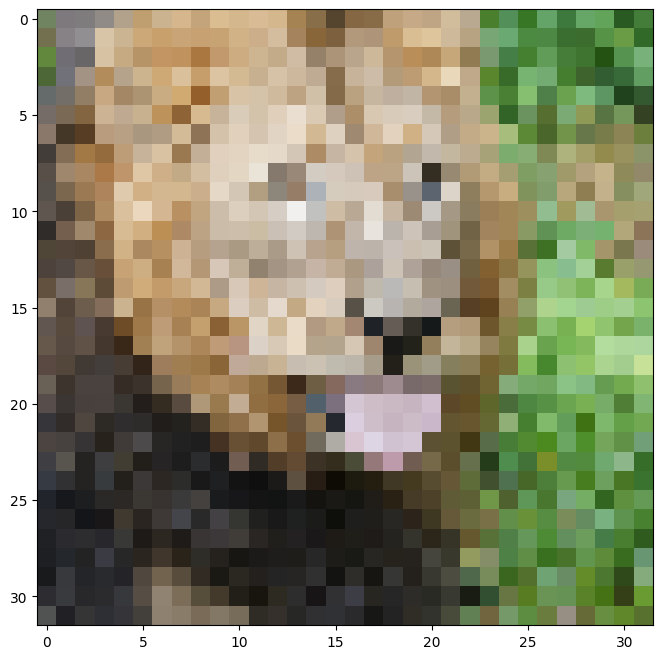

  0%|          | 0/5 [00:00<?, ?it/s]

training none


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.11558189, test_loss:0.11663631
Epoch 50, train_loss:0.06217930, test_loss:0.06715567
Epoch 100, train_loss:0.04446293, test_loss:0.04767587
Epoch 150, train_loss:0.03965253, test_loss:0.04416221
Epoch 200, train_loss:0.03663717, test_loss:0.04222149
Epoch 250, train_loss:0.03406586, test_loss:0.04024927
Epoch 300, train_loss:0.03661170, test_loss:0.04376223
Epoch 350, train_loss:0.03382731, test_loss:0.04288080
Epoch 400, train_loss:0.02686107, test_loss:0.03672583
Epoch 450, train_loss:0.02613616, test_loss:0.03664971
Epoch 500, train_loss:0.02442015, test_loss:0.03548258
Epoch 550, train_loss:0.02406196, test_loss:0.03839842
Epoch 600, train_loss:0.01989105, test_loss:0.03352493
Epoch 650, train_loss:0.02137236, test_loss:0.03402643
Epoch 700, train_loss:0.01885233, test_loss:0.03331436
Epoch 750, train_loss:0.01666949, test_loss:0.03262109
Epoch 800, train_loss:0.01674106, test_loss:0.03535678
Epoch 850, train_loss:0.01341217, test_loss:0.03297192
Epoch 900, tr

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.06965637, test_loss:0.07276494
Epoch 50, train_loss:0.01896301, test_loss:0.03306632
Epoch 100, train_loss:0.00752916, test_loss:0.03263293
Epoch 150, train_loss:0.00367811, test_loss:0.03432819
Epoch 200, train_loss:0.00127444, test_loss:0.03379934
Epoch 250, train_loss:0.00099720, test_loss:0.03434375
Epoch 300, train_loss:0.00033305, test_loss:0.03366550
Epoch 350, train_loss:0.00119021, test_loss:0.03510344
Epoch 400, train_loss:0.00018075, test_loss:0.03403141
Epoch 450, train_loss:0.00114268, test_loss:0.03433101
Epoch 500, train_loss:0.00165169, test_loss:0.03614707
Epoch 550, train_loss:0.00012651, test_loss:0.03340278
Epoch 600, train_loss:0.00098879, test_loss:0.03345328
Epoch 650, train_loss:0.00090374, test_loss:0.03363244
Epoch 700, train_loss:0.00017704, test_loss:0.03345258
Epoch 750, train_loss:0.00205701, test_loss:0.03476322
Epoch 800, train_loss:0.00009951, test_loss:0.03302974
Epoch 850, train_loss:0.00022375, test_loss:0.03297458
Epoch 900, tr

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.05144755, test_loss:0.05336803
Epoch 50, train_loss:0.00719561, test_loss:0.03350478
Epoch 100, train_loss:0.00144522, test_loss:0.03220779
Epoch 150, train_loss:0.00067406, test_loss:0.03094559
Epoch 200, train_loss:0.00074848, test_loss:0.03247055
Epoch 250, train_loss:0.00005668, test_loss:0.03090452
Epoch 300, train_loss:0.00171320, test_loss:0.03198329
Epoch 350, train_loss:0.00014254, test_loss:0.03069156
Epoch 400, train_loss:0.00005704, test_loss:0.03058874
Epoch 450, train_loss:0.00004365, test_loss:0.03060495
Epoch 500, train_loss:0.00115629, test_loss:0.03150211
Epoch 550, train_loss:0.00004349, test_loss:0.03006519
Epoch 600, train_loss:0.00003425, test_loss:0.03034065
Epoch 650, train_loss:0.00009305, test_loss:0.03016637
Epoch 700, train_loss:0.00013339, test_loss:0.03007951
Epoch 750, train_loss:0.00059136, test_loss:0.03091786
Epoch 800, train_loss:0.00000727, test_loss:0.03087893
Epoch 850, train_loss:0.00002395, test_loss:0.03106498
Epoch 900, tr

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.09684630, test_loss:0.13852685
Epoch 50, train_loss:0.00001987, test_loss:0.10693654
Epoch 100, train_loss:0.00019923, test_loss:0.10570013
Epoch 150, train_loss:0.00030908, test_loss:0.10523377
Epoch 200, train_loss:0.00012191, test_loss:0.10407146
Epoch 250, train_loss:0.00014522, test_loss:0.10314603
Epoch 300, train_loss:0.00000163, test_loss:0.10206724
Epoch 350, train_loss:0.00000000, test_loss:0.10206588
Epoch 400, train_loss:0.00000045, test_loss:0.10206200
Epoch 450, train_loss:0.00041343, test_loss:0.10207244
Epoch 500, train_loss:0.00027203, test_loss:0.10130792
Epoch 550, train_loss:0.00007516, test_loss:0.10128506
Epoch 600, train_loss:0.00001546, test_loss:0.10121474
Epoch 650, train_loss:0.00019145, test_loss:0.10174850
Epoch 700, train_loss:0.00031901, test_loss:0.10181437
Epoch 750, train_loss:0.00000012, test_loss:0.10164732
Epoch 800, train_loss:0.00000703, test_loss:0.10171089
Epoch 850, train_loss:0.00024037, test_loss:0.10089536
Epoch 900, tr

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.10335049, test_loss:0.14104159
Epoch 50, train_loss:0.00041730, test_loss:0.13579652
Epoch 100, train_loss:0.00015072, test_loss:0.13264282
Epoch 150, train_loss:0.00009675, test_loss:0.13207721
Epoch 200, train_loss:0.00001454, test_loss:0.13209723
Epoch 250, train_loss:0.00112455, test_loss:0.13033604
Epoch 300, train_loss:0.00001189, test_loss:0.13023097
Epoch 350, train_loss:0.00003952, test_loss:0.13076746
Epoch 400, train_loss:0.00034004, test_loss:0.13010871
Epoch 450, train_loss:0.00005045, test_loss:0.12963246
Epoch 500, train_loss:0.00028370, test_loss:0.12989648
Epoch 550, train_loss:0.00003107, test_loss:0.12993772
Epoch 600, train_loss:0.00042253, test_loss:0.12768180
Epoch 650, train_loss:0.00011412, test_loss:0.13079262
Epoch 700, train_loss:0.00018269, test_loss:0.13093777
Epoch 750, train_loss:0.00008026, test_loss:0.13066731
Epoch 800, train_loss:0.00013772, test_loss:0.13134424
Epoch 850, train_loss:0.00009075, test_loss:0.13266428
Epoch 900, tr

In [117]:
outputs = {}
size = 32
train_data, test_data = get_image(size)
B_dict = get_B_dict()
opt = "Adam"
for k in tqdm(B_dict):
    print("\n========== training", k)
    outputs[k] = train_wrapper(train_data, test_data, B_dict, k, size, opt)

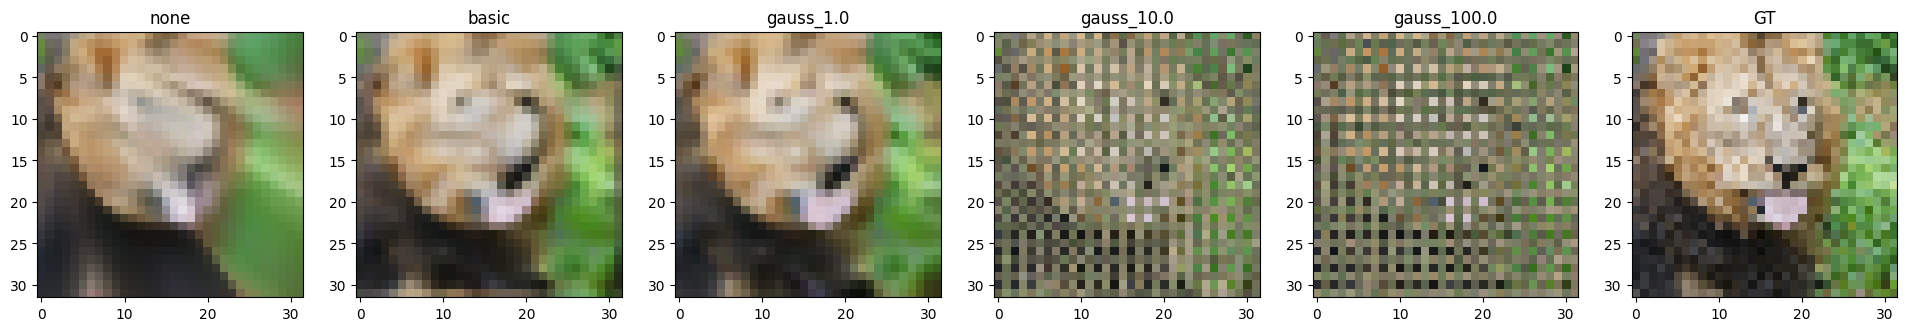

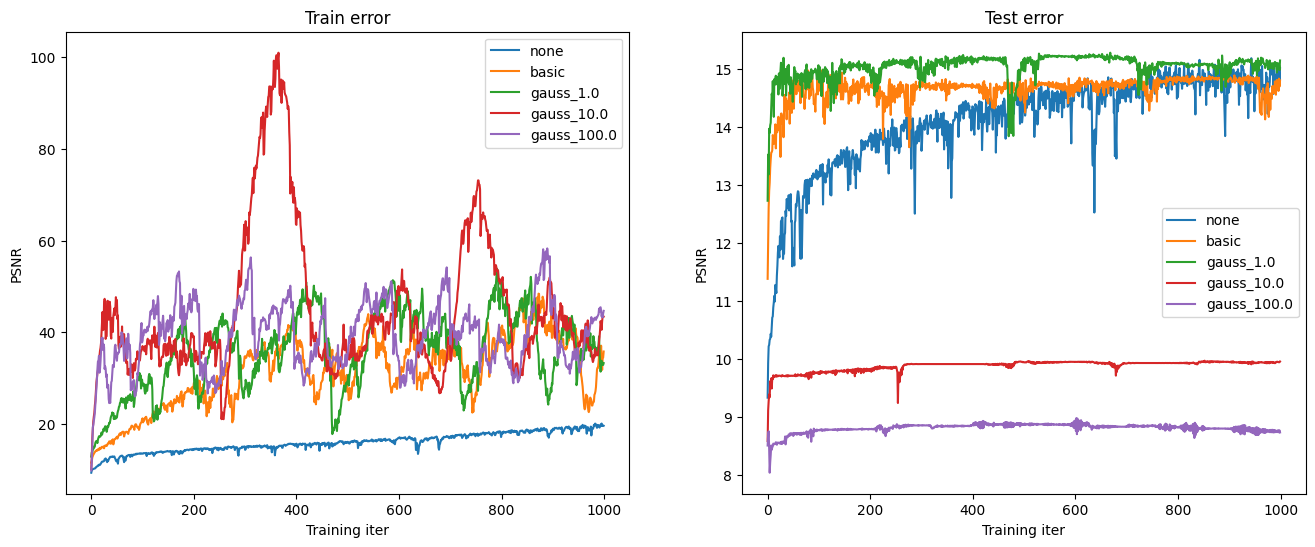

In [118]:
# if you did everything correctly so far, this should output a nice figure you can use in your report
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

# High Resolution Reconstruction

#### High Resolution Reconstruction - Optimizer of your Choice - Various Input Mapping Stategies

Repeat the previous experiment, but at the higher resolution. The reason why we have you first experiment with the lower resolution since it is faster to train and debug. Additionally, you will see how the mapping strategies perform better or worse at the two different input resolutions. 

/tmp/ipykernel_5476/1395671467.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


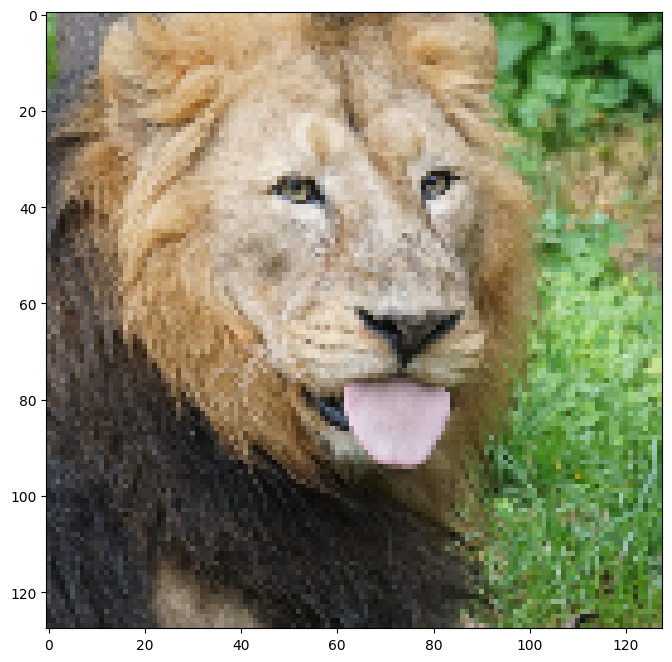

In [138]:
size = 128
train_data, test_data = get_image(size)

In [133]:
outputs = {}
B_dict = get_B_dict()
opt = "Adam"
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(train_data, test_data, B_dict, k, size, opt)

  0%|          | 0/5 [00:00<?, ?it/s]

training none


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.08713234, test_loss:0.08732894
Epoch 50, train_loss:0.03171514, test_loss:0.03212758
Epoch 100, train_loss:0.02523438, test_loss:0.02594487
Epoch 150, train_loss:0.02593011, test_loss:0.02647460
Epoch 200, train_loss:0.02070035, test_loss:0.02161312
Epoch 250, train_loss:0.02174143, test_loss:0.02297252
Epoch 300, train_loss:0.01881777, test_loss:0.02025690
Epoch 350, train_loss:0.01853168, test_loss:0.02020592
Epoch 400, train_loss:0.01763160, test_loss:0.01950643
Epoch 450, train_loss:0.01606772, test_loss:0.01822284
Epoch 500, train_loss:0.01622926, test_loss:0.01880398
Epoch 550, train_loss:0.01590985, test_loss:0.01834041
Epoch 600, train_loss:0.01567735, test_loss:0.01799455
Epoch 650, train_loss:0.01386551, test_loss:0.01686202
Epoch 700, train_loss:0.01350698, test_loss:0.01656386
Epoch 750, train_loss:0.01508972, test_loss:0.01830296
Epoch 800, train_loss:0.01248895, test_loss:0.01594730
Epoch 850, train_loss:0.01302018, test_loss:0.01642970
Epoch 900, tr

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.04587160, test_loss:0.04666168
Epoch 50, train_loss:0.01846196, test_loss:0.02114402
Epoch 100, train_loss:0.01492835, test_loss:0.01797241
Epoch 150, train_loss:0.01235630, test_loss:0.01666242
Epoch 200, train_loss:0.01048721, test_loss:0.01553863
Epoch 250, train_loss:0.00896340, test_loss:0.01492798
Epoch 300, train_loss:0.00843651, test_loss:0.01470541
Epoch 350, train_loss:0.00702844, test_loss:0.01362499
Epoch 400, train_loss:0.00639624, test_loss:0.01343414
Epoch 450, train_loss:0.00548426, test_loss:0.01379904
Epoch 500, train_loss:0.00539292, test_loss:0.01379390
Epoch 550, train_loss:0.00557404, test_loss:0.01451789
Epoch 600, train_loss:0.00476481, test_loss:0.01379356
Epoch 650, train_loss:0.00456334, test_loss:0.01367008
Epoch 700, train_loss:0.00384021, test_loss:0.01359943
Epoch 750, train_loss:0.00388354, test_loss:0.01388488
Epoch 800, train_loss:0.00362886, test_loss:0.01350378
Epoch 850, train_loss:0.00312285, test_loss:0.01334360
Epoch 900, tr

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.03420483, test_loss:0.03449287
Epoch 50, train_loss:0.01681258, test_loss:0.01883646
Epoch 100, train_loss:0.01234358, test_loss:0.01587469
Epoch 150, train_loss:0.00936857, test_loss:0.01480876
Epoch 200, train_loss:0.00687635, test_loss:0.01356511
Epoch 250, train_loss:0.00507454, test_loss:0.01295900
Epoch 300, train_loss:0.00471447, test_loss:0.01278368
Epoch 350, train_loss:0.00318602, test_loss:0.01227899
Epoch 400, train_loss:0.00259563, test_loss:0.01223338
Epoch 450, train_loss:0.00273232, test_loss:0.01217002
Epoch 500, train_loss:0.00201812, test_loss:0.01185542
Epoch 550, train_loss:0.00171424, test_loss:0.01155957
Epoch 600, train_loss:0.00212712, test_loss:0.01177807
Epoch 650, train_loss:0.00158148, test_loss:0.01210787
Epoch 700, train_loss:0.00431219, test_loss:0.01386465
Epoch 750, train_loss:0.00175676, test_loss:0.01198930
Epoch 800, train_loss:0.00123465, test_loss:0.01180175
Epoch 850, train_loss:0.00174609, test_loss:0.01243356
Epoch 900, tr

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.04082757, test_loss:0.04671705
Epoch 50, train_loss:0.00137010, test_loss:0.01251404
Epoch 100, train_loss:0.00056047, test_loss:0.01159528
Epoch 150, train_loss:0.00020034, test_loss:0.01107281
Epoch 200, train_loss:0.00017450, test_loss:0.01117443
Epoch 250, train_loss:0.00052360, test_loss:0.01151182
Epoch 300, train_loss:0.00014446, test_loss:0.01125494
Epoch 350, train_loss:0.00004762, test_loss:0.01112519
Epoch 400, train_loss:0.00028329, test_loss:0.01135918
Epoch 450, train_loss:0.00013915, test_loss:0.01120504
Epoch 500, train_loss:0.00003964, test_loss:0.01129363
Epoch 550, train_loss:0.00014273, test_loss:0.01149972
Epoch 600, train_loss:0.00052741, test_loss:0.01180366
Epoch 650, train_loss:0.00004586, test_loss:0.01118776
Epoch 700, train_loss:0.00009134, test_loss:0.01122824
Epoch 750, train_loss:0.00010568, test_loss:0.01138514
Epoch 800, train_loss:0.00013010, test_loss:0.01145140
Epoch 850, train_loss:0.00010565, test_loss:0.01140040
Epoch 900, tr

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, train_loss:0.14046689, test_loss:0.14863033
Epoch 50, train_loss:0.00184955, test_loss:0.13399399
Epoch 100, train_loss:0.00200505, test_loss:0.13737828
Epoch 150, train_loss:0.00039242, test_loss:0.13486260
Epoch 200, train_loss:0.00014322, test_loss:0.13659077
Epoch 250, train_loss:0.00011278, test_loss:0.13868385
Epoch 300, train_loss:0.00029667, test_loss:0.13928899
Epoch 350, train_loss:0.00062025, test_loss:0.14141936
Epoch 400, train_loss:0.00070618, test_loss:0.14382693
Epoch 450, train_loss:0.00024908, test_loss:0.14534433
Epoch 500, train_loss:0.00005363, test_loss:0.14739122
Epoch 550, train_loss:0.00023858, test_loss:0.14756493
Epoch 600, train_loss:0.00002993, test_loss:0.14985166
Epoch 650, train_loss:0.00008754, test_loss:0.14900457
Epoch 700, train_loss:0.00018806, test_loss:0.14860324
Epoch 750, train_loss:0.00071991, test_loss:0.14929874
Epoch 800, train_loss:0.00037311, test_loss:0.15309703
Epoch 850, train_loss:0.00053141, test_loss:0.15364834
Epoch 900, tr

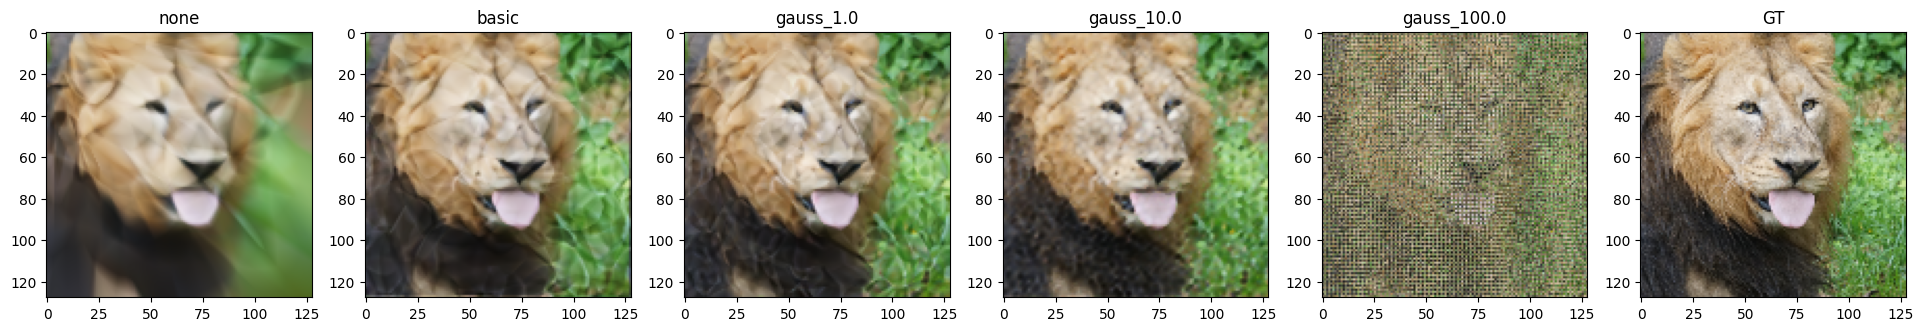

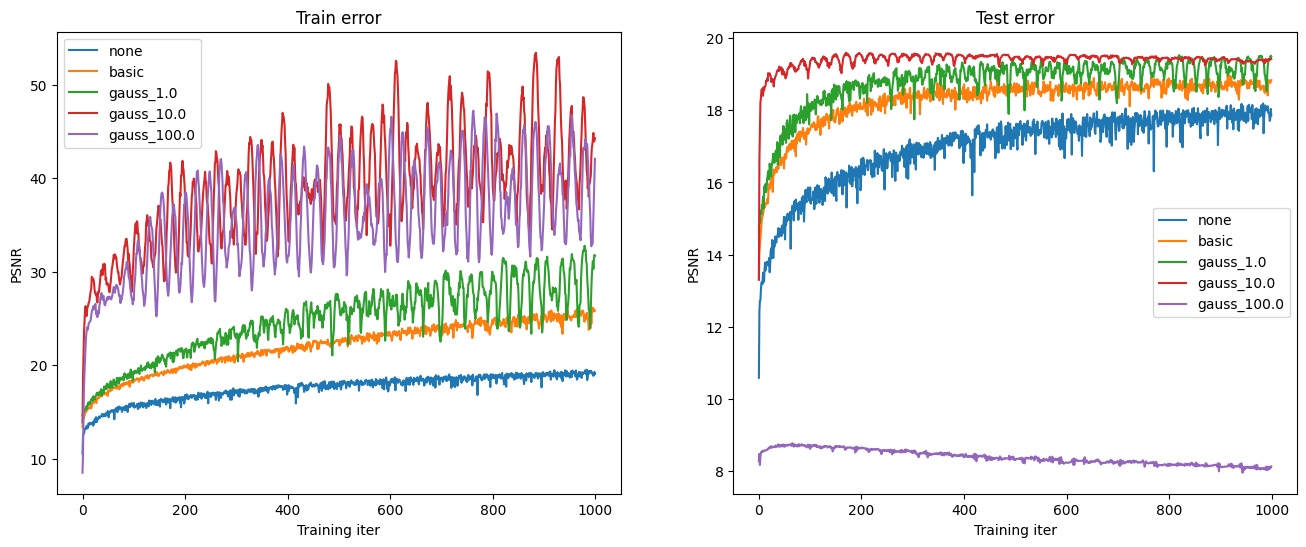

In [141]:
_, _, _, y_test = get_input_features(train_data, test_data, B_dict, mapping="none")
# if you did everything correctly so far, this should output a nice figure you can use in your report
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

#### High Resolution Reconstruction - Image of your Choice

When choosing an image select one that you think will give you interesting results or a better insight into the performance of different feature mappings and explain why in your report template. 

In [134]:
size = 128
# TODO pick an image and replace the url string
train_data, test_data = get_image(size, image_url="YOUR URL HERE")

/tmp/ipykernel_5476/1395671467.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


FileNotFoundError: No such file: '/home/kaiwenjon/Documents/Spring2023/Deep-Learning-for-CV/spring2023/MP2/assignment2/assignment2/YOUR URL HERE'

In [ ]:
# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions

# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function

plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

# Reconstruction Process Video (Optional)
(For Fun!) Visualize the progress of training in a video 

In [142]:
# requires installing this additional dependency
!pip install imageio-ffmpeg

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 21.5 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [150]:
# single video example
create_and_visualize_video({"gauss": {"pred_imgs": predicted_images}}, filename="training_high_res_gauss.mp4", epochs=1000, size=32)

In [145]:
# multi video example
create_and_visualize_video(outputs, epochs=1000, size=128)

,,,,
none,basic,gauss_1.0,gauss_10.0,gauss_100.0
